# EE541: Skin lesion segmenation and Border detection using Ensemble UNet's

# Importing Required Libraries

In [1]:
import os
import random
import numpy as np
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision.transforms import Compose, ToTensor, Normalize, Lambda
from torchvision.models import resnet34
from torchvision import transforms
from torchvision.models import resnet34
from PIL import Image
from sklearn.metrics import confusion_matrix
from torchvision.utils import make_grid
import torchsummary as summary
from sklearn.metrics import jaccard_score, f1_score
import torch.nn.functional as F

e:\EE559\.conda\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Processing and Getting the data ready for training 

In [5]:
def preprocess_labels(labels, threshold=0.5):
    return (labels > threshold).float()

class DermoscopicDataset(Dataset):
    def __init__(self, image_dir, label_dir, image_transform=None, label_transform=None):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.image_transform = image_transform
        self.label_transform = label_transform

        self.image_filenames = sorted(os.listdir(image_dir))
        self.label_filenames = sorted(os.listdir(label_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.image_dir, self.image_filenames[idx])
        label_path = os.path.join(self.label_dir, self.label_filenames[idx])

        image = Image.open(image_path)
        label = Image.open(label_path)

        if self.image_transform:
            image = self.image_transform(image)
        if self.label_transform:
            label = self.label_transform(label)

        return image, label


In [6]:
image_dir = r'E:\EE 541\Project\HAM-4000'
label_dir = r'E:\EE 541\Project\Part_Processed_HAM_Segmentations'

image_transforms = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization values
])
label_transforms = Compose([
    ToTensor(),
    Lambda(preprocess_labels),
])
dataset = DermoscopicDataset(image_dir, label_dir, image_transform=image_transforms, label_transform=label_transforms)
train_loader = DataLoader(dataset, batch_size=32, shuffle=True)

# Visualization of Train image and Its Corresponding Ground truth

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


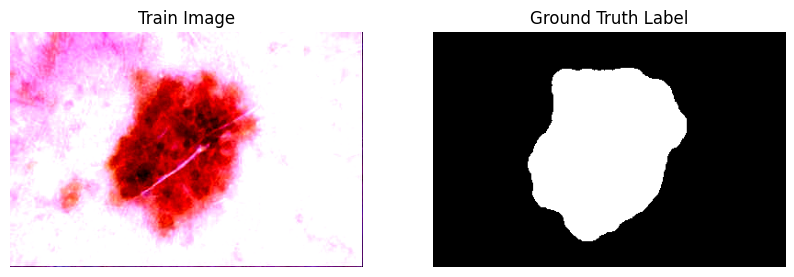

In [10]:
def visualize_sample(image, label):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))

    # Display the image
    ax1.imshow(image)
    ax1.set_title('Train Image')
    ax1.axis('off')

    # Display the ground truth label
    ax2.imshow(label, cmap='gray')
    ax2.set_title('Ground Truth Label')
    ax2.axis('off')

    plt.show()

# Get a batch of samples from the train_loader
images, labels = next(iter(train_loader))

# Select the first image and label from the batch
image, label = images[0], labels[0]

# Convert tensors back to numpy arrays for visualization
image = image.permute(1, 2, 0).numpy()
label = label.squeeze().numpy()

# Visualize the sample
visualize_sample(image, label)


# Unet Model Architecture with Depth 3

In [11]:
class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, batchnorm=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UNetDepth3(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True):
        super().__init__()

        self.encoder = nn.Sequential(
            Conv2dBlock(in_channels, n_filters, 3, batchnorm),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters, n_filters * 2, 3, batchnorm),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 2, n_filters * 4, 3, batchnorm)
        )

        self.middle = Conv2dBlock(n_filters * 4, n_filters * 8, 3, batchnorm)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_filters * 8, n_filters * 4, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 4, n_filters * 2, 3, batchnorm),
            nn.ConvTranspose2d(n_filters * 2, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters, n_filters, 3, batchnorm)
        )

        self.out_conv = nn.Conv2d(n_filters, out_channels, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        middle = self.middle(enc)
        dec = self.decoder(middle)
        return torch.sigmoid(self.out_conv(dec))

# Unet Model Architecture with Depth 4

In [ ]:
import torch
import torch.nn as nn

class Conv2dBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, batchnorm=True):
        super().__init__()
        layers = [
            nn.Conv2d(in_channels, out_channels, kernel_size, padding=1),
            nn.ReLU(inplace=True)
        ]
        if batchnorm:
            layers.append(nn.BatchNorm2d(out_channels))
        self.block = nn.Sequential(*layers)

    def forward(self, x):
        return self.block(x)

class UNetDepth4(nn.Module):
    def __init__(self, in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True):
        super().__init__()

        self.encoder = nn.Sequential(
            Conv2dBlock(in_channels, n_filters, 3, batchnorm),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters, n_filters * 2, 3, batchnorm),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 2, n_filters * 4, 3, batchnorm),
            nn.MaxPool2d(2),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 4, n_filters * 8, 3, batchnorm)
        )

        self.middle = Conv2dBlock(n_filters * 8, n_filters * 16, 3, batchnorm)

        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(n_filters * 16, n_filters * 8, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 8, n_filters * 4, 3, batchnorm),
            nn.ConvTranspose2d(n_filters * 4, n_filters * 2, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters * 2, n_filters, 3, batchnorm),
            nn.ConvTranspose2d(n_filters, n_filters, kernel_size=3, stride=2, padding=1, output_padding=1),
            nn.Dropout(dropout),
            Conv2dBlock(n_filters, n_filters, 3, batchnorm)
        )

        self.out_conv = nn.Conv2d(n_filters, out_channels, kernel_size=1)

    def forward(self, x):
        enc = self.encoder(x)
        middle = self.middle(enc)
        dec = self.decoder(middle)
        return torch.sigmoid(self.out_conv(dec))



# Loss Function

In [12]:
class JaccardLoss(nn.Module):
    def __init__(self, smooth=1):
        super(JaccardLoss, self).__init__()
        self.smooth = smooth

    def forward(self, y_pred, y_true):
        intersection = torch.sum(y_pred * y_true)
        union = torch.sum(y_pred) + torch.sum(y_true) - intersection
        return 1 - ((intersection + self.smooth) / (union + self.smooth))

# Model Training

In [13]:
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision.transforms import Compose, Resize, ToTensor
from sklearn.metrics import jaccard_score
import copy

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

input_channels = 3
output_channels = 1
n_filters = 16

# Create an instance of the model
model = UNetDepth3(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)

# Loss function
criterion = JaccardLoss()

# Optimizer
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Scheduler
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=5)

# Split the dataset into train and validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoader for train and validation
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Function to calculate Jaccard index
def jaccard_index(pred, target):
    pred = pred.cpu().numpy()
    target = target.cpu().numpy()
    return jaccard_score(target.flatten(), pred.flatten(), average='binary')

# Training
num_epochs = 15
best_val_acc = 0
best_model = None
history = []

for epoch in range(num_epochs):
    train_loss = 0
    train_acc = 0
    train_jaccard = 0
    val_loss = 0
    val_acc = 0
    val_jaccard = 0

    # Train
    model.train()
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()

        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        preds = (outputs > 0.5).float()
        acc = (preds == labels).float().mean()
        jaccard = jaccard_index(preds, labels)

        train_loss += loss.item()
        train_acc += acc.item()
        train_jaccard += jaccard

    train_loss /= len(train_loader)
    train_acc /= len(train_loader)
    train_jaccard /= len(train_loader)

    # Validation
    model.eval()
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            preds = (outputs > 0.5).float()
            acc = (preds == labels).float().mean()
            jaccard = jaccard_index(preds, labels)

            val_loss += loss.item()
            val_acc += acc.item()
            val_jaccard += jaccard

        val_loss /= len(val_loader)
        val_acc /= len(val_loader)
        val_jaccard /= len(val_loader)

    scheduler.step(val_loss)

    history.append({
        'epoch': epoch + 1,
        'train_loss': train_loss,
        'val_loss': val_loss,
        'train_acc': train_acc,
        'val_acc': val_acc,
        'train_jaccard': train_jaccard,
        'val_jaccard': val_jaccard
    })

    # Save the best model based on validation accuracy
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model = copy.deepcopy(model.state_dict())

    # Print metrics for this epoch
    print(f"Epoch {epoch + 1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")
    print(f"Train Acc: {train_acc:.4f}, Val Acc: {val_acc:.4f}")
    print(f"Train Jaccard: {train_jaccard:.4f}, Val Jaccard: {val_jaccard:.4f}")
    print("-" * 50)

# Save the best model
torch.save(best_model, "best_model.pth")

Epoch 1/15
Train Loss: 0.5592, Val Loss: 0.4591
Train Acc: 0.8049, Val Acc: 0.8405
Train Jaccard: 0.5334, Val Jaccard: 0.5922
--------------------------------------------------
Epoch 2/15
Train Loss: 0.4386, Val Loss: 0.3793
Train Acc: 0.8591, Val Acc: 0.8862
Train Jaccard: 0.6096, Val Jaccard: 0.6482
--------------------------------------------------
Epoch 3/15
Train Loss: 0.3987, Val Loss: 0.3750
Train Acc: 0.8714, Val Acc: 0.8893
Train Jaccard: 0.6242, Val Jaccard: 0.6406
--------------------------------------------------
Epoch 4/15
Train Loss: 0.3758, Val Loss: 0.3639
Train Acc: 0.8786, Val Acc: 0.8896
Train Jaccard: 0.6377, Val Jaccard: 0.6500
--------------------------------------------------
Epoch 5/15
Train Loss: 0.3673, Val Loss: 0.3467
Train Acc: 0.8826, Val Acc: 0.8870
Train Jaccard: 0.6413, Val Jaccard: 0.6604
--------------------------------------------------
Epoch 6/15
Train Loss: 0.3494, Val Loss: 0.3423
Train Acc: 0.8895, Val Acc: 0.8919
Train Jaccard: 0.6569, Val Jacca

# Training Learning Curves 

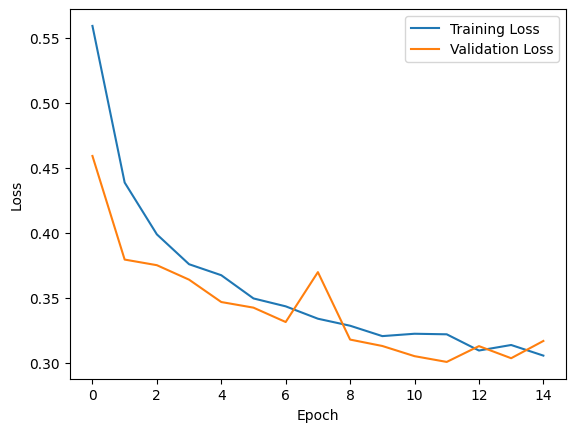

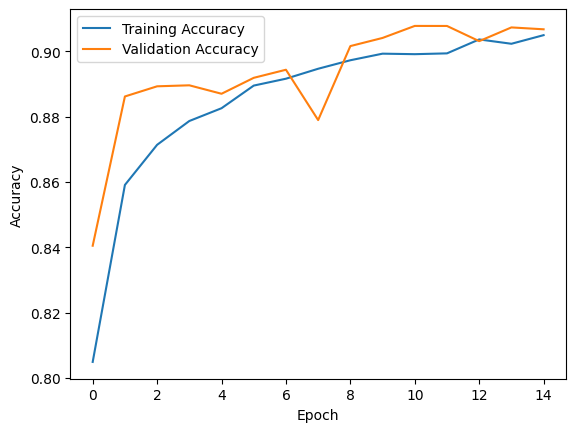

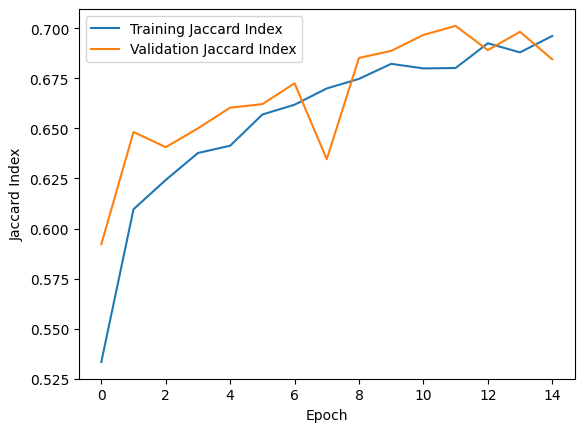

In [59]:
import matplotlib.pyplot as plt

# Get the training and validation loss and accuracy
train_loss = [h['train_loss'] for h in history]
val_loss = [h['val_loss'] for h in history]
train_acc = [h['train_acc'] for h in history]
val_acc = [h['val_acc'] for h in history]
train_jaccard = [h['train_jaccard'] for h in history]
val_jaccard = [h['val_jaccard'] for h in history]

# Plot the training and validation loss
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot the training and validation accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot the training and validation loss
plt.plot(train_jaccard, label='Training Jaccard Index')
plt.plot(val_jaccard, label='Validation Jaccard Index')
plt.xlabel('Epoch')
plt.ylabel('Jaccard Index')
plt.legend()
plt.show()


# Evaluation on the PH2 Testdataset:

In [15]:
from torchvision.transforms import Compose, Resize, RandomHorizontalFlip, RandomVerticalFlip, ToTensor, Normalize

test_image_dir = r'E:\EE 541\Project\PH2Dataset\dermoscopic_images'
test_label_dir = r'E:\EE 541\Project\PH2Dataset\lesion_masks'

image_transforms = Compose([
    ToTensor(),
    Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # ImageNet normalization values
])

label_transforms = Compose([
    ToTensor(),
    Lambda(preprocess_labels),
])

test_dataset = DermoscopicDataset(test_image_dir, test_label_dir, image_transform=image_transforms, label_transform=label_transforms)

# Create DataLoader for test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)


## Evaluation Metrics

In [16]:
def jaccard_index(pred, target):
    intersection = torch.sum(pred * target)
    union = torch.sum(pred) + torch.sum(target) - intersection
    return (intersection + 1e-6) / (union + 1e-6)

def dice_coefficient(pred, target):
    intersection = torch.sum(pred * target)
    dice = (2 * intersection + 1e-6) / (torch.sum(pred) + torch.sum(target) + 1e-6)
    return dice


In [17]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, jaccard_score, f1_score
from torch.utils.data import DataLoader

# Load the saved best model
model = UNetDepth3(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model.load_state_dict(torch.load('best_model_depth_3.pth', map_location=device))
model.to(device)


# Set the model to evaluation mode
model.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize arrays to store the predictions and labels
y_pred = []
y_true = []

# Iterate over the test dataset to get the predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert the predictions and labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate the accuracy, sensitivity, Jaccard score, and dice coefficient
accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
sensitivity = recall_score(y_true.ravel(), y_pred.ravel())
jaccard = jaccard_score(y_true.ravel(), y_pred.ravel())
dice = f1_score(y_true.ravel(), y_pred.ravel())

# Calculate the average values of the accuracy, sensitivity, Jaccard score, and dice coefficient
avg_accuracy = np.mean(accuracy)
avg_sensitivity = np.mean(sensitivity)
avg_jaccard = np.mean(jaccard)
avg_dice = np.mean(dice)


# Print the results
print(f"Average Accuracy on PH2 Test Dataset: {avg_accuracy:.4f}")
print(f"Average Sensitivity on PH2 Test Dataset: {avg_sensitivity:.4f}")
print(f"Average Jaccard Score on PH2 Test Dataset: {avg_jaccard:.4f}")
print(f"Average Dice Coefficient on PH2 Test Dataset: {avg_dice:.4f}")


Average Accuracy on PH2 Test Dataset: 0.8570
Average Sensitivity on PH2 Test Dataset: 0.9002
Average Jaccard Score on PH2 Test Dataset: 0.6698
Average Dice Coefficient on PH2 Test Dataset: 0.8023


In [18]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, jaccard_score, f1_score
from torch.utils.data import DataLoader

# Load the saved best model
model = UNetDepth4(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model.load_state_dict(torch.load('best_model_depth_4.pth', map_location=device))
model.to(device)


# Set the model to evaluation mode
model.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize arrays to store the predictions and labels
y_pred = []
y_true = []

# Iterate over the test dataset to get the predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs = model(images)
        preds = (outputs > 0.5).float()
        y_pred.extend(preds.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert the predictions and labels to numpy arrays
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Calculate the accuracy, sensitivity, Jaccard score, and dice coefficient
accuracy = accuracy_score(y_true.ravel(), y_pred.ravel())
sensitivity = recall_score(y_true.ravel(), y_pred.ravel())
jaccard = jaccard_score(y_true.ravel(), y_pred.ravel())
dice = f1_score(y_true.ravel(), y_pred.ravel())

# Calculate the average values of the accuracy, sensitivity, Jaccard score, and dice coefficient
avg_accuracy = np.mean(accuracy)
avg_sensitivity = np.mean(sensitivity)
avg_jaccard = np.mean(jaccard)
avg_dice = np.mean(dice)


# Print the results
print(f"Average Accuracy on PH2 Test Dataset: {avg_accuracy:.4f}")
print(f"Average Sensitivity on PH2 Test Dataset: {avg_sensitivity:.4f}")
print(f"Average Jaccard Score on PH2 Test Dataset: {avg_jaccard:.4f}")
print(f"Average Dice Coefficient on PH2 Test Dataset: {avg_dice:.4f}")


Average Accuracy on PH2 Test Dataset: 0.8947
Average Sensitivity on PH2 Test Dataset: 0.7939
Average Jaccard Score on PH2 Test Dataset: 0.7084
Average Dice Coefficient on PH2 Test Dataset: 0.8293


In [23]:
import torch
import numpy as np
from sklearn.metrics import accuracy_score, recall_score, jaccard_score, f1_score
from torch.utils.data import DataLoader

# Load the saved best models
model1 = UNetDepth3(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model1.load_state_dict(torch.load('best_model_depth_3.pth', map_location=device))
model1.to(device)

model2 = UNetDepth4(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model2.load_state_dict(torch.load('best_model_depth_4.pth', map_location=device))
model2.to(device)

# Set the models to evaluation mode
model1.eval()
model2.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize arrays to store the predictions and labels
y_pred1 = []
y_pred2 = []
y_true = []

# Iterate over the test dataset to get the predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs1 = model1(images)
        preds1 = (outputs1 > 0.5).float()

        outputs2 = model2(images)
        preds2 = (outputs2 > 0.5).float()

        y_pred1.extend(preds1.cpu().numpy())
        y_pred2.extend(preds2.cpu().numpy())
        y_true.extend(labels.cpu().numpy())

# Convert the predictions and labels to numpy arrays
y_pred1 = np.array(y_pred1)
y_pred2 = np.array(y_pred2)
y_true = np.array(y_true)

# Combine the predictions of both models by taking the average
y_pred_ensemble = ((y_pred1 + y_pred2) / 2) >= 0.5

# Calculate the accuracy, sensitivity, Jaccard score, and dice coefficient of the ensemble predictions
accuracy = accuracy_score(y_true.ravel(), y_pred_ensemble.ravel())
sensitivity = recall_score(y_true.ravel(), y_pred_ensemble.ravel())
jaccard = jaccard_score(y_true.ravel(), y_pred_ensemble.ravel())
dice = f1_score(y_true.ravel(), y_pred_ensemble.ravel())

# Print the results
print(f"Accuracy on PH2 Test Dataset (Ensemble): {accuracy:.4f}")
print(f"Sensitivity on PH2 Test Dataset (Ensemble): {sensitivity:.4f}")
print(f"Jaccard Score on PH2 Test Dataset (Ensemble): {jaccard:.4f}")
print(f"Dice Coefficient on PH2 Test Dataset (Ensemble): {dice:.4f}")


Accuracy on PH2 Test Dataset (Ensemble): 0.8561
Sensitivity on PH2 Test Dataset (Ensemble): 0.9287
Jaccard Score on PH2 Test Dataset (Ensemble): 0.6754
Dice Coefficient on PH2 Test Dataset (Ensemble): 0.8063


In [24]:
import numpy as np

# Perform majority voting on the predicted labels
y_pred_ensemble = np.round((y_pred1 + y_pred2) / 2)
y_pred_ensemble[y_pred_ensemble < 0.5] = 0
y_pred_ensemble[y_pred_ensemble >= 0.5] = 1

# Calculate the accuracy, sensitivity, Jaccard score, and dice coefficient
accuracy = accuracy_score(y_true.ravel(), y_pred_ensemble.ravel())
sensitivity = recall_score(y_true.ravel(), y_pred_ensemble.ravel())
jaccard = jaccard_score(y_true.ravel(), y_pred_ensemble.ravel())
dice = f1_score(y_true.ravel(), y_pred_ensemble.ravel())

# Calculate the average values of the accuracy, sensitivity, Jaccard score, and dice coefficient
avg_accuracy = np.mean(accuracy)
avg_sensitivity = np.mean(sensitivity)
avg_jaccard = np.mean(jaccard)
avg_dice = np.mean(dice)

# Print the results
print(f"Average Accuracy on PH2 Test Dataset(majority voting): {avg_accuracy:.4f}")
print(f"Average Sensitivity on PH2 Test Dataset(majority voting): {avg_sensitivity:.4f}")
print(f"Average Jaccard Score on PH2 Test Dataset(majority voting): {avg_jaccard:.4f}")
print(f"Average Dice Coefficient on PH2 Test Dataset(majority voting): {avg_dice:.4f}")


Average Accuracy on PH2 Test Dataset(majority voting): 0.8955
Average Sensitivity on PH2 Test Dataset(majority voting): 0.7654
Average Jaccard Score on PH2 Test Dataset(majority voting): 0.7025
Average Dice Coefficient on PH2 Test Dataset(majority voting): 0.8252


In [26]:
# Load the saved models
model1 = UNetDepth3(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model1.load_state_dict(torch.load('best_model_depth_3.pth', map_location=device))
model1.to(device)

model2 = UNetDepth4(in_channels=3, out_channels=1, n_filters=16, dropout=0.1, batchnorm=True)
model2.load_state_dict(torch.load('best_model_depth_4.pth', map_location=device))
model2.to(device)

# Set the models to evaluation mode
model1.eval()
model2.eval()

# Create a DataLoader for the test dataset
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize arrays to store the predictions and labels
y_pred1 = []
y_pred2 = []
y_true = []

# Iterate over the test dataset to get the predictions and labels
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outputs1 = model1(images)
        preds1 = (outputs1 > 0.5).float()
        y_pred1.extend(preds1.cpu().numpy())

        outputs2 = model2(images)
        preds2 = (outputs2 > 0.5).float()
        y_pred2.extend(preds2.cpu().numpy())

        y_true.extend(labels.cpu().numpy())

# Convert the predictions and labels to numpy arrays
y_pred1 = np.array(y_pred1)
y_pred2 = np.array(y_pred2)
y_true = np.array(y_true)

# Apply weighted averaging to the predictions
y_pred_ensemble = (0.25 * y_pred1 + 0.75 * y_pred2) / 2
y_pred_ensemble[y_pred_ensemble < 0.5] = 0
y_pred_ensemble[y_pred_ensemble >= 0.5] = 1

# Calculate the accuracy, sensitivity, Jaccard score, and dice coefficient
accuracy = accuracy_score(y_true.ravel(), y_pred_ensemble.ravel())
sensitivity = recall_score(y_true.ravel(), y_pred_ensemble.ravel())
jaccard = jaccard_score(y_true.ravel(), y_pred_ensemble.ravel())
dice = f1_score(y_true.ravel(), y_pred_ensemble.ravel())

# Print the results
print(f"Accuracy on PH2 Test Dataset(weighted averaging): {accuracy:.4f}")
print(f"Sensitivity on PH2 Test Dataset(weighted averaging): {sensitivity:.4f}")
print(f"Jaccard Score on PH2 Test Datase(weighted averaging): {jaccard:.4f}")
print(f"Dice Coefficient on PH2 Test Dataset(weighted averaging): {dice:.4f}")


Accuracy on PH2 Test Dataset(weighted averaging): 0.8955
Sensitivity on PH2 Test Dataset(weighted averaging): 0.7654
Jaccard Score on PH2 Test Datase(weighted averaging): 0.7025
Dice Coefficient on PH2 Test Dataset(weighted averaging): 0.8252


# Visualizing the Predicted Label and Skin lesion border detection

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


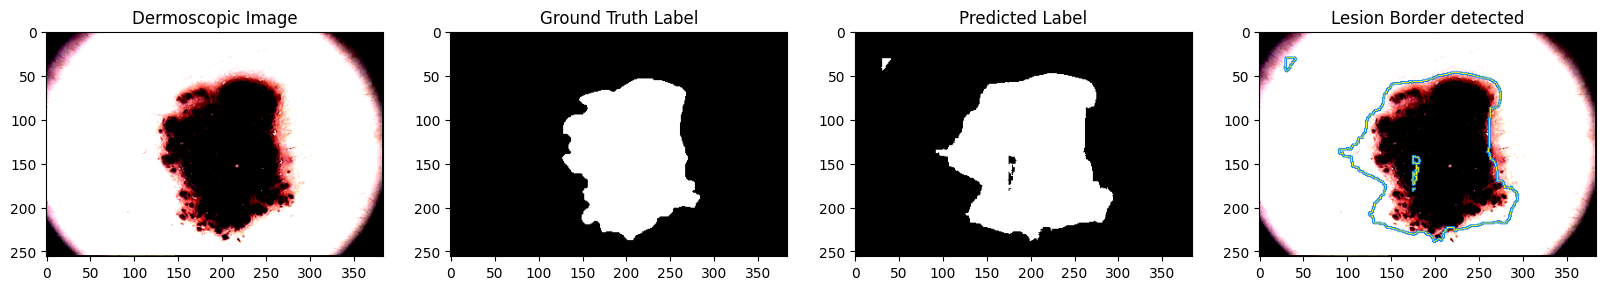

In [61]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


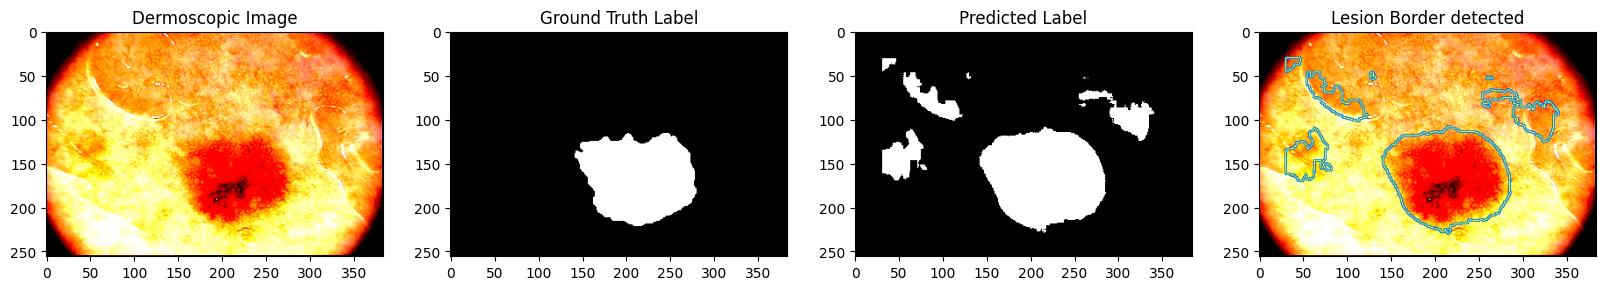

In [36]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


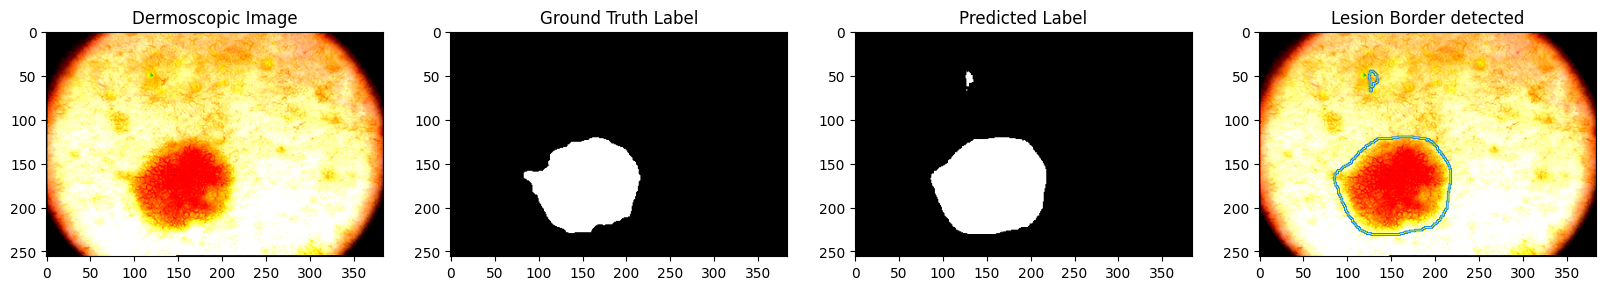

In [37]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


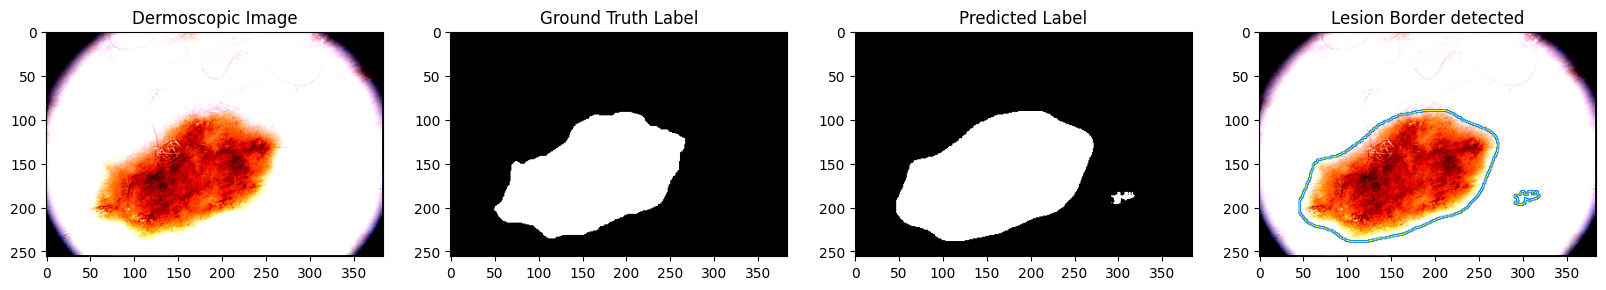

In [38]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


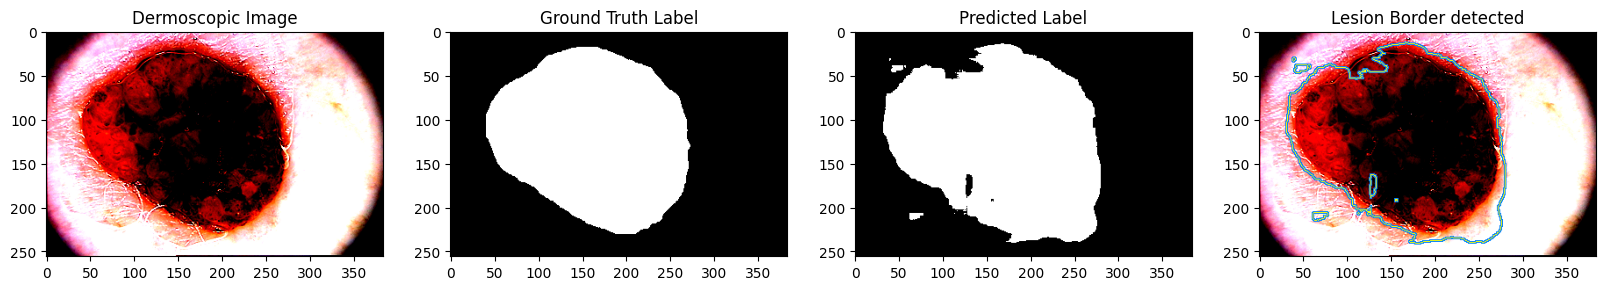

In [40]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


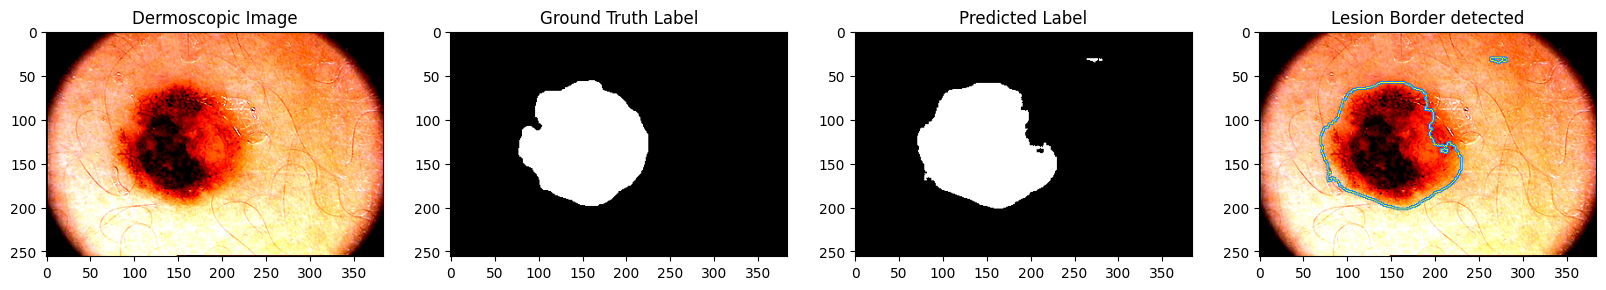

In [45]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


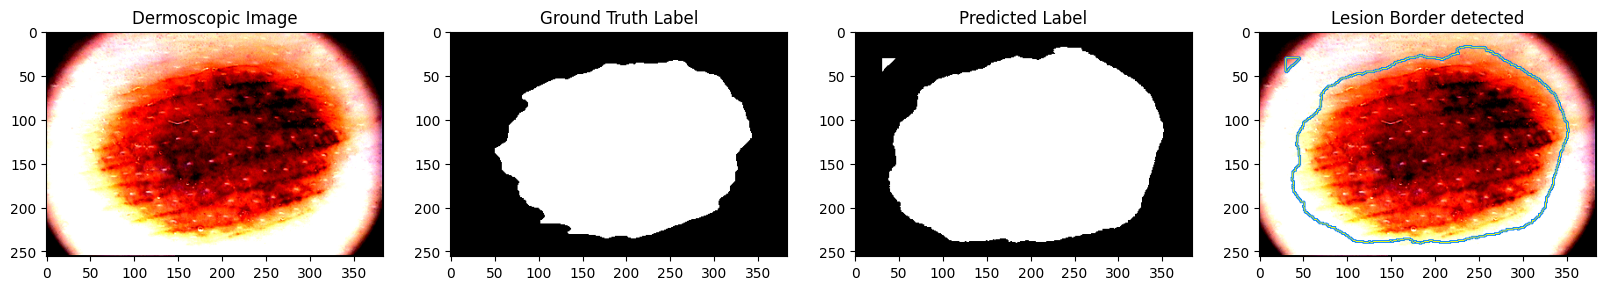

In [56]:
import matplotlib.pyplot as plt
from skimage.segmentation import mark_boundaries

# Select a random image from the test dataset
index = np.random.randint(len(test_dataset))
image, label = test_dataset[index]

# Get the predicted label for the selected image
with torch.no_grad():
    image = image.unsqueeze(0).to(device)
    output = model2(image)
    pred = (output > 0.5).squeeze().cpu().numpy()

# Plot the original image, ground truth label, predicted label, and contours
fig, axes = plt.subplots(1, 4, figsize=(20, 5))
axes[0].imshow(image.squeeze().permute(1, 2, 0).cpu())
axes[0].set_title("Dermoscopic Image")
axes[1].imshow(label.squeeze(), cmap='gray')
axes[1].set_title("Ground Truth Label")
axes[2].imshow(pred, cmap='gray')
axes[2].set_title("Predicted Label")
axes[3].imshow(mark_boundaries(image.squeeze().cpu().numpy().transpose(1, 2, 0), pred, outline_color=(0, 0.5, 1)))
axes[3].set_title("Lesion Border detected")
plt.show()
